# Audio-to-Text Conversion


In [ ]:
# Kernel preparation

# Warning suppression
import warnings
warnings.simplefilter('ignore')
import numpy as np
np.warnings.filterwarnings('ignore')
np.random.seed(1001)
# Cliche
import os
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import sys
import shutil
from pathlib import Path
import IPython
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook
from sklearn.model_selection import StratifiedKFold
%matplotlib inline
matplotlib.style.use('ggplot')

# Function to play audio
def play_audio(data):
    IPython.display.display(IPython.display.Audio(data=data))

In [ ]:
# Dataset preparation

# Root folder that contains entire dataset
#DATAROOT = Path.home() / '.kaggle/competitions/freesound-audio-tagging'
DATAROOT = Path('../input') / 'freesound-audio-tagging'
# Root folder that contains extra data provided by this kernel
import tarfile
tar = tarfile.open(Path('../input') / 'fsd2018extra' / 'fsd2018_extra.tgz')
tar.extractall()
tar.close()
EXTRA = Path('.') / 'fsd2018_extra'
# Prepare train/test dataset
df_train = pd.read_csv(DATAROOT / 'train.csv')
df_test = pd.read_csv(DATAROOT / 'sample_submission.csv')
# Labels and integer converter
labels = df_train.label.unique()
label2int = {l:i for i, l in enumerate(labels)}
num_classes = len(labels)
# Train data sample index of manually verified ones
train_verified_idx = np.array(df_train[df_train.manually_verified == 1].index)
# Plain y_train label
plain_y_train = np.array([label2int[label] for label in df_train.label])

In [ ]:
## External dependencies - mixup & random eraser
# 2 augmentation techniques: MixupGenerator and RandomEraser

import numpy as np

# MixupGenerator
# Mixes 2 audio samples by combining them linearly
class MixupGenerator():
    def __init__(self, X_train, y_train, batch_size=32, alpha=0.2, shuffle=True, datagen=None):
        self.X_train = X_train
        self.y_train = y_train
        self.batch_size = batch_size
        self.alpha = alpha
        self.shuffle = shuffle
        self.sample_num = len(X_train)
        self.datagen = datagen

    def __call__(self):
        while True:
            indexes = self.__get_exploration_order()
            itr_num = int(len(indexes) // (self.batch_size * 2))

            for i in range(itr_num):
                batch_ids = indexes[i * self.batch_size * 2:(i + 1) * self.batch_size * 2]
                X, y = self.__data_generation(batch_ids)

                yield X, y

    def __get_exploration_order(self):
        indexes = np.arange(self.sample_num)

        if self.shuffle:
            np.random.shuffle(indexes)

        return indexes

    def __data_generation(self, batch_ids):
        _, h, w, c = self.X_train.shape
        l = np.random.beta(self.alpha, self.alpha, self.batch_size) # Use Beta Distribution to determine mixing ratios
        X_l = l.reshape(self.batch_size, 1, 1, 1)
        y_l = l.reshape(self.batch_size, 1)

        X1 = self.X_train[batch_ids[:self.batch_size]]
        X2 = self.X_train[batch_ids[self.batch_size:]]
        X = X1 * X_l + X2 * (1 - X_l)

        if self.datagen:
            for i in range(self.batch_size):
                X[i] = self.datagen.random_transform(X[i])
                X[i] = self.datagen.standardize(X[i])

        if isinstance(self.y_train, list):
            y = []

            for y_train_ in self.y_train:
                y1 = y_train_[batch_ids[:self.batch_size]]
                y2 = y_train_[batch_ids[self.batch_size:]]
                y.append(y1 * y_l + y2 * (1 - y_l))
        else:
            y1 = self.y_train[batch_ids[:self.batch_size]]
            y2 = self.y_train[batch_ids[self.batch_size:]]
            y = y1 * y_l + y2 * (1 - y_l)

        return X, y

# Eraser Function
# Randomly removes parts of audio file(of random size)
# Replaces erased area with random pixel intensity
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255):
    def eraser(input_img):
        img_h, img_w, _ = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        c = np.random.uniform(v_l, v_h)
        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

## Our Methodology

Adopt two different approaches,final result is ensemble of both results.
The 2 approaches are:

- LH: Uses highest feature resolution, but only with beginning part of sounds.
- X: Uses coarser feature resolution, however splits samples and uses all the samples long enough

By combining these models, we have high resolution as well as captures it for a longer portion of the audio file.

- Useful information typically tends to be around the starting part of the audio considering how we record and edit target sound. This assumption was supported by good results of approach LH which uses only the beginning some seconds.
- However it fails with audio samples that has important content in the middle or later parts. To address this drawback, we used X that uses the entire sample audio wave.

We now create 2 dictionaries conflH and confX to store configurations for the both approaches, where each configuration correspond to a specific method for processing audio data.

In [ ]:
confLH, confX = {}, {}
confs = [confLH, confX]
confLH['folder'] = Path('LH') # directory for LH approach
confX['folder'] = Path('X') # directory for X approach

# Remove Noise
## Blacklist for Making Clean Training Dataset

Training dataset contains clearly labelled data, weak but clean data which is mostly consistent with their labels and dirty data that may be silent, poor sound quality or no association with label.

Presence of dirty data may greatly derail performance of model.Hence, we manually removed them by predicting and making a list of samples which the model failed to predict.Then, we checked the failed samples one by one manually, and put dirty samples on blacklist.We repeated this till no poor samples were found.

In [ ]:
# Prints no of blacklisted items and the respective items
train_blacklist_index = np.load(EXTRA / 'train_blacklist.npy')
print('Blacklist has %d items.' % len(train_blacklist_index))
print(train_blacklist_index)

Blacklist has 59 items.
[  45  368  552  579  777  849  852 1142 1185 1768 1852 2011 2266 2300
 2643 2694 2900 3430 3863 4507 4511 4584 4877 4909 5108 5265 5333 5629
 5685 6156 6205 6453 7211 7369 7435 7607 7751 8026 8248 8447 8469 8715
 8721 8867 9063 9235  253  613  848 1906 2299 3212 5027 5058 5715 5753
 5956 7645 8274]


## Preprocess and Convert Data

All the train and test data are converted in advance, so that we can simply load it when training.

We have some audio parameters here which performance of models depends on.

In [ ]:
# Approach LH parameters: highest resolutions
confLH['sampling_rate'] = 44100
confLH['duration'] = 4
confLH['hop_length'] = 882 # 20ms
confLH['fmin'] = 20
confLH['fmax'] = confLH['sampling_rate'] // 2
confLH['n_mels'] = 128
confLH['n_fft'] = confLH['n_mels'] * 20
confLH['audio_split'] = 'head' # processes only start of audio file

# Approach X uses longer sound, then it uses suppressed
confX['sampling_rate'] = 26000
confX['duration'] = 6
confX['hop_length'] = 520 # 20ms
confX['fmin'] = 20
confX['fmax'] = confX['sampling_rate'] // 2
confX['n_mels'] = 48
confX['n_fft'] = confX['n_mels'] * 20
confX['audio_split'] = 'dont_crop' # processes full audio file

# Auto calculate other configuration paramters

def auto_complete_conf(conf):
    conf['samples'] = conf['sampling_rate'] * conf['duration']
    conf['dims'] = (conf['n_mels'], 1 + int(np.floor(conf['samples']/conf['hop_length'])), 1)

# Autocalculates derived parameters like total samples
auto_complete_conf(confLH)
auto_complete_conf(confX)

### Preprocessing functions

- read_audio: Ensuring a fixed length by truncating if longer or padding if shorter.
- audio_to_melspectrogram: Convert audio samples into mel-spectrogram data.
- read_as_melspectrogram: Do both above.

In [ ]:
import librosa
import librosa.display

def read_audio(conf, pathname):
    y, sr = librosa.load(pathname, sr=conf['sampling_rate'])
    # trim silence
    if 0 < len(y): # workaround: 0 length causes error
        y, _ = librosa.effects.trim(y) # trim, top_db=default(60)
    # make it unified length to conf.samples
    if len(y) > conf['samples']: # long enough
        if conf['audio_split'] == 'head':
            y = y[0:0+conf['samples']]
    else: # pad blank
        padding = conf['samples'] - len(y)    # add padding at both ends
        offset = padding // 2
        y = np.pad(y, (offset, conf['samples'] - len(y) - offset), 'constant')
    return y

def audio_to_melspectrogram(conf, audio):
    spectrogram = librosa.feature.melspectrogram(audio,
                                                 sr=conf['sampling_rate'],
                                                 n_mels=conf['n_mels'],
                                                 hop_length=conf['hop_length'],
                                                 n_fft=conf['n_fft'],
                                                 fmin=conf['fmin'],
                                                 fmax=conf['fmax'])
    spectrogram = librosa.power_to_db(spectrogram)
    spectrogram = spectrogram.astype(np.float32)
    return spectrogram

def show_melspectrogram(mels, conf):
    librosa.display.specshow(mels, x_axis='time', y_axis='mel',
                             sr=conf['sampling_rate'], hop_length=conf['hop_length'],
                            fmin=conf['fmin'], fmax=conf['fmax'])
    plt.colorbar(format='%+2.0f dB')
    plt.title('Log-frequency power spectrogram')
    plt.show()

def read_as_melspectrogram(conf, pathname, debug_display=False):
    x = read_audio(conf, pathname)
    mels = audio_to_melspectrogram(conf, x)
    if debug_display:
        IPython.display.display(IPython.display.Audio(x, rate=conf['sampling_rate']))
        show_melspectrogram(mels, conf)
    return mels

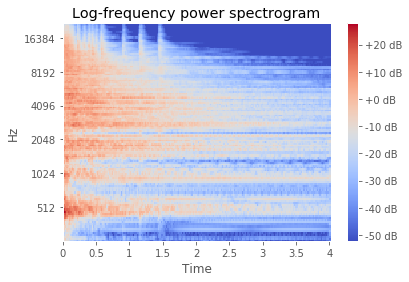

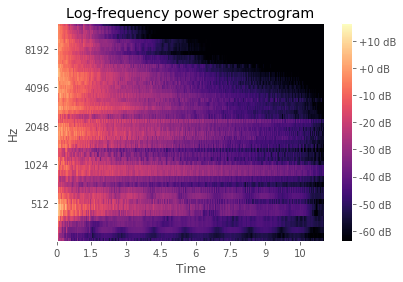

In [ ]:
# Preprocessing example, verify preprocessing
_ = read_as_melspectrogram(confLH, DATAROOT / 'audio_train' / df_train.fname[0], debug_display=True)
_ = read_as_melspectrogram(confX, DATAROOT / 'audio_train' / df_train.fname[0], debug_display=True)

LH has fine-grained features for 4 seconds, and  X has more abstract whole sample for 11 seconds.

### Converter

In [ ]:
def split_long_data(conf, X):
    # Splits long mel-spectrogram data with small overlap
    L = X.shape[1]
    one_length = conf['dims'][1]
    loop_length = int(one_length * 0.9) # Uses 90% overlap for feature extraction
    min_length = int(one_length * 0.2)
    print(' sample length', L, 'to cut every', one_length)
    for idx in range(L // loop_length):
        cur = loop_length * idx
        rest = L - cur
        if one_length <= rest:
            yield X[:, cur:cur+one_length]
        elif min_length <= rest:
            cur = L - one_length
            yield X[:, cur:cur+one_length]

def convert_X(df, conf, datapath):
    # Convert all audio files listed on df.fname
    # Then generates X (contains mel-spectrograms)
    # and index mapping to original sample order
    X = []
    index_map = []
    for i, fname in enumerate(df.fname): # for every file
        print('processing', fname)
        data = read_as_melspectrogram(conf, datapath / fname)
        for chunk in split_long_data(conf, data):
            X.append(np.expand_dims(chunk, axis=-1))
            index_map.append(i)
    return np.array(X), np.array(index_map)

# Converts training labels to match processed data indices
def convert_y_train(idx_train, plain_y_train):
    return np.array( [plain_y_train[idx] for idx in idx_train])

In [ ]:
# Example - process up to 10 samples
print('All samples will be cut per split length (=duration)')
X_train, idx_train = convert_X(df_train[:10], confX, DATAROOT / 'audio_train')
y_train = convert_y_train(idx_train, plain_y_train)
print('Now original 10 samples were cut into ', len(idx_train), 'samples.')
print()
print('idx_train holds original sample index, y_train is also converted to have the same length with X_train/idx_train.')
print('idx_train', idx_train)
print('y_train', y_train)

All samples will be cut per split length (=duration)
processing 00044347.wav
 sample length 578 to cut every 301
processing 001ca53d.wav
 sample length 517 to cut every 301
processing 002d256b.wav
 sample length 301 to cut every 301
processing 0033e230.wav
 sample length 301 to cut every 301
processing 00353774.wav
 sample length 301 to cut every 301
processing 003b91e8.wav
 sample length 665 to cut every 301
processing 003da8e5.wav
 sample length 301 to cut every 301
processing 0048fd00.wav
 sample length 301 to cut every 301
processing 004ad66f.wav
 sample length 351 to cut every 301
processing 0063ab88.wav
 sample length 1483 to cut every 301
Now original 10 samples were cut into  16 samples.

idx_train holds original sample index, y_train is also converted to have the same length with X_train/idx_train.
idx_train [0 0 1 2 3 4 5 5 6 7 8 9 9 9 9 9]
y_train [0 0 1 2 3 4 4 4 5 6 7 8 8 8 8 8]


## Create Dataset Files

Now convert all the data and store them on files.

Toy example dataset which is subset of whole samples will be prepared by default, for running on Kaggle kernel.

In [ ]:
# Data utilities
def datapath(conf, filename):
    return conf['folder'] / filename

def loaddata(conf, filename):
    return np.load(conf['folder'] / filename)

TRYING_AS_TOY = True # For a subset of the sample

for conf in confs:
    conf['folder'].mkdir(parents=True, exist_ok=True)
    if TRYING_AS_TOY:
        for file in ['X_train', 'y_train', 'idx_train', 'X_test', 'idx_test']:
            shutil.copy(EXTRA/datapath(conf, file+'.npy'), datapath(conf, file+'.npy'))
        plain_y_train = np.load(EXTRA/'toy_plain_y_train.npy')
        train_verified_idx = np.load(EXTRA/'toy_train_verified_idx.npy')
        train_blacklist_index = np.load(EXTRA / 'toy_train_blacklist.npy')
    else:
        if not os.path.exists(datapath(conf, 'X_train.npy')):
            X_train, idx_train = convert_X(df_train, conf, DATAROOT / 'audio_train')
            y_train = convert_y_train(idx_train, plain_y_train)
            np.save(datapath(conf, 'X_train.npy'), X_train)
            np.save(datapath(conf, 'y_train.npy'), y_train)
            np.save(datapath(conf, 'idx_train.npy'), idx_train)

            X_test, idx_test = convert_X(df_test, conf, DATAROOT / 'audio_test')
            np.save(datapath(conf, 'X_test.npy'), X_test)
            np.save(datapath(conf, 'idx_test.npy'), idx_test)

## Models

AlexNet based model is enabled by default for Kaggle kernel.

In [ ]:
import keras
from keras.layers import Dense, Conv2D, AveragePooling2D
from keras.layers import MaxPooling2D, GlobalAveragePooling2D, Dropout, BatchNormalization, Flatten
from keras.models import Model, Sequential

def create_model(conf, num_classes):
    input_shape = conf['dims'] # height, width and channels
    if False: # SE-ResNet
        from se_resnet import SEResNet
        model = SEResNet(input_shape=input_shape,
               width=1,
               bottleneck=True,
               weight_decay=1e-4,
               include_top=True,
               depth=[3, 4, 4, 3],
               filters=[32, 64, 128, 256],
               weights=None,
               input_tensor=None,
               pooling=None,
               classes=num_classes)
    elif False: # VGG16
        from keras.applications.vgg16 import VGG16
        base_model = VGG16(weights=None, input_shape=input_shape, include_top=False) # pretrained model
        x = GlobalAveragePooling2D()(base_model.output) # GAP for classification
        x = Dense(1024, activation='relu')(x)
        predictions = Dense(num_classes, activation='softmax')(x)
        model = Model(inputs=base_model.input, outputs=predictions)
    else: # AlexNet
        model = Sequential()
        model.add(Conv2D(48, 11,  input_shape=input_shape, strides=(2,3), activation='relu', padding='same'))
        model.add(MaxPooling2D(3, strides=(1,2)))
        model.add(BatchNormalization())
        model.add(Conv2D(128, 5, strides=(2,3), activation='relu', padding='same'))
        model.add(MaxPooling2D(3, strides=2)) # Reduces feature map size
        model.add(BatchNormalization()) # Enhances training stability
        model.add(Conv2D(192, 3, strides=(1, 2), activation='relu', padding='same')) # Applies 192 filters of size 3 * 3 with ReLU activation
        model.add(Conv2D(192, 3, strides=(1, 1), activation='relu', padding='same'))
        model.add(Conv2D(128, 3, strides=(1, 1), activation='relu', padding='same'))
        model.add(MaxPooling2D(3, strides=(1,2)))
        model.add(BatchNormalization())
        model.add(Flatten())
        model.add(Dense(256, activation='relu'))
        model.add(Dropout(0.5)) # Flattens the 2D feature maps into 1D vector
        model.add(Dense(256, activation='relu')) # 256 neuron dense layer with ReLU activation
        model.add(Dropout(0.5)) # To prevent overfitting
        model.add(Dense(num_classes, activation='softmax')) # Converts output into probabilitites for classification later

    model.compile(loss='categorical_crossentropy', # multi-class classification
              optimizer=keras.optimizers.Adam(lr=conf['learning_rate']),
              metrics=['accuracy'])
    model.summary() # Returns model architecture and no of parameters
    return model

## Training

Prepare dataset for training.

## Analyse and address class imabalance in dataset

In [ ]:
# Calculates the distribution of samples across different classes in the dataset
def get_class_distribution(y):
    # y_cls can be one of [OH label, index of class, class label name]
    # convert OH to index of class
    y_cls = [np.argmax(one) for one in y] if len(np.array(y).shape) == 2 else y
    # y_cls can be one of [index of class, class label name]
    classset = sorted(list(set(y_cls)))
    sample_distribution = {cur_cls:len([one for one in y_cls if one == cur_cls]) for cur_cls in classset}
    return sample_distribution
# Transforms the class distribution dictionary into a list format.
def get_class_distribution_list(y, num_classes):
    dist = get_class_distribution(y)
    assert(y[0].__class__ != str) # class index or class OH label only
    list_dist = np.zeros((num_classes))
    for i in range(num_classes):
        if i in dist:
            list_dist[i] = dist[i]
    return list_dist

from imblearn.over_sampling import RandomOverSampler
# Addresses the class imbalance by oversampling the minority classes
def balance_class_by_over_sampling(X, y):
    Xidx = [[xidx] for xidx in range(len(X))]
    y_cls = [np.argmax(one) for one in y]
    classset = sorted(list(set(y_cls)))
    sample_distribution = [len([one for one in y_cls if one == cur_cls]) for cur_cls in classset]
    nsamples = np.max(sample_distribution)
    flat_ratio = {cls:nsamples for cls in classset}
    Xidx_resampled, y_cls_resampled = RandomOverSampler(ratio=flat_ratio, random_state=42).fit_sample(Xidx, y_cls)
    sampled_index = [idx[0] for idx in Xidx_resampled]
    return np.array([X[idx] for idx in sampled_index]), np.array([y[idx] for idx in sampled_index])

def visualize_class_balance(title, y, labels):
    sample_dist_list = get_class_distribution_list(y, len(labels))
    index = range(len(labels))
    fig, ax = plt.subplots(1, 1, figsize = (16, 5))
    ax.bar(index, sample_dist_list)
    ax.set_xlabel('Label')
    ax.set_xticks(index)
    ax.set_xticklabels(labels, rotation='vertical')
    ax.set_ylabel('Number of Samples')
    ax.set_title(title)
    fig.show()

def print_class_balance(title, y, labels):
    distributions = get_class_distribution(y)
    dist_dic = {labels[cls]:distributions[cls] for cls in distributions}
    print(title, '=', dist_dic)
    zeroclasses = [label for i, label in enumerate(labels) if i not in distributions.keys()]
    if 0 < len(zeroclasses):
        print(' 0 sample classes:', zeroclasses)

### Dataset related Utilities

Augemntation done by data generators.

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
# Creates 2 objects called train_generator and valid_generator
def create_generators(conf, _Xtrain, _ytrain, _Xvalid, _yvalid):
    # Create Keras ImageDataGenerator
    aug_datagen = ImageDataGenerator(
        featurewise_center=conf['normalize'] == 'featurewise',
        featurewise_std_normalization=conf['normalize'] == 'featurewise',
        rotation_range=0,
        width_shift_range=0.4,
        height_shift_range=0.0,
        horizontal_flip=True,
        preprocessing_function=get_random_eraser(v_l=-1, v_h=1)
    )
    plain_datagen = ImageDataGenerator(
        featurewise_center=aug_datagen.featurewise_center,
        featurewise_std_normalization=aug_datagen.featurewise_std_normalization,
    )
    # Set featurewise normalization mean/std
    if aug_datagen.featurewise_center:
        print(' normalize featurewise')
        aug_datagen.mean, aug_datagen.std = np.mean(_Xtrain), np.std(_Xtrain)
        plain_datagen.mean, plain_datagen.std = aug_datagen.mean, aug_datagen.std

    train_generator = MixupGenerator(_Xtrain, _ytrain,
                                     alpha=1.0, batch_size=conf['batch_size'], datagen=aug_datagen)()
    valid_generator = plain_datagen.flow(_Xvalid, _yvalid,
                                         batch_size=conf['batch_size'], shuffle=False)
    return train_generator, valid_generator, plain_datagen
# Calculates the number of steps (batches) per epoch for training and validation
def get_steps_per_epoch(conf, _Xtrain, _Xvalid):
    train_steps_per_epoch = len(_Xtrain) // conf['batch_size']
    valid_steps_per_epoch = len(_Xvalid) // conf['batch_size']
    return train_steps_per_epoch, valid_steps_per_epoch
# Performs sample-wise normalization.
def samplewise_mean_X(X):
    for i in range(len(X)):
        X[i] -= np.mean(X[i], keepdims=True)
        X[i] /= (np.std(X[i], keepdims=True) + 1.0) # Kind of Compressor effect

### Fold Generator & Trainer

In [ ]:
from sklearn.model_selection import train_test_split
# Prepare the data for training ML model(by k-fold cross validation)
def get_cross_valid_fold_balanced(conf, fold, X_train, y_train, idx_train):
    indices = np.array(range(len(X_train)))
    # Cross validation split -> _Xtrain|_ytrain, _Xvalid|_yvalid
    _, _, _, _, train_fold, valid_fold = train_test_split(X_train, y_train, indices,
                                                          test_size=conf['test_size'],
                                                          random_state=conf['random_state'] + fold*10)
    _Xtrain, _ytrain = X_train[train_fold], y_train[train_fold]

    # Validation set to filter non-verified samples if requested
    if conf['valid_limit'] == 'manually_verified_only':
        filtered = [idx for idx in valid_fold if idx_train[idx] in train_verified_idx]
        print(' valid set is filtered to verified samples only, %d -> %d' % (len(valid_fold), len(filtered)))
        valid_fold = filtered
    _Xvalid, _yvalid = X_train[valid_fold], y_train[valid_fold]

    # Balance distribution -> _Xtrain|_ytrain (overwritten)
    print_class_balance('Current fold category distribution', _ytrain, labels)
    _Xtrain, _ytrain = balance_class_by_over_sampling(_Xtrain, _ytrain)
    print_class_balance('after balanced', _ytrain, labels)

    return _Xtrain, _ytrain, _Xvalid, _yvalid

from keras.callbacks import (EarlyStopping, LearningRateScheduler,
                             ModelCheckpoint, TensorBoard, ReduceLROnPlateau)
from keras import backend as K
# Creates model, loads pre-trained weight, sets callbacks and fits model to data
def train_model(conf, fold, model, train_generator, valid_generator,
                train_steps_per_epoch, valid_steps_per_epoch,
                init_best_weights=False, this_epochs=None):
    callbacks = [
        ModelCheckpoint(str(datapath(conf, 'best_%d.h5' % fold)),
                        monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True),
        TensorBoard(log_dir=str(datapath(conf, 'logs%s/fold_%d' % (conf['folder'], fold))), write_graph=True)
    ]
    # Create model
    if model is None:
        model = create_model(conf, num_classes)
        #if fold == 0:
        #    model.summary()
        # Load weights
        weight_filename = str(init_best_weights) # for when file name was set
        if weight_filename == 'True': weight_filename = str(datapath(conf, 'best_%d.h5' % fold))
        if weight_filename is not 'False':
            print(' Initializing model with last best weights:', weight_filename)
            model.load_weights(weight_filename)
    # Train model
    history = model.fit_generator(train_generator,
                    steps_per_epoch=train_steps_per_epoch,
                    epochs=conf['epochs'] if this_epochs is None else this_epochs,
                    validation_data=valid_generator,
                    validation_steps=valid_steps_per_epoch,
                    callbacks=callbacks,
                    verbose=conf['verbose'])
    return model, history

### More training utilities

In [ ]:
# Calculates the geometric mean of a set of predictions
def geometric_mean_preds(_preds):
    preds = _preds.copy()
    for i in range(1, preds.shape[0]):
        preds[0] = np.multiply(preds[0], preds[i])
    return preds[0]
# Unifies predictions for each original sample potentially split into several audio chunks by taking geometric mean
def get_unified_preds(preds, pred_idx, N):
    mean_results = []
    for idx in range(N):
        this_preds = preds[np.where(pred_idx == idx)]
        if len(this_preds) <= 0:
            print(' no result: %d' % idx)
            mean_results.append(np.ones((preds.shape[1],)))
        else:
            mean_results.append(geometric_mean_preds(this_preds))
    return np.array(mean_results)
# Evaluate accuracy of unified predictions
def evaluate_pred_acc(y, uni_preds, idx_map, N):
    uni_y = []
    for idx in range(N):
        uni_y.append(y[np.where(idx_map == idx)[0]][0])
    uni_y = np.array(uni_y)

    refs = np.argmax(uni_y, axis=1)
    results = np.argmax(uni_preds, axis=1)
    acc = np.sum(refs == results) / len(refs)
    n_verified = len(refs[train_verified_idx])
    acc_verified = np.sum(refs[train_verified_idx] == results[train_verified_idx]) / n_verified
    return acc, acc_verified
# Evaluate model performance on a specific fold of the data
def evaluate_fold(conf, fold, filenametmpl, model, plain_datagen, X, idx_map, y=None, verified_idx=None):
    # predict
    _y = keras.utils.to_categorical(np.ones((len(X)))) if y is None else y
    test_generator = plain_datagen.flow(X, _y, batch_size=conf['batch_size'], shuffle=False)
    preds = model.predict_generator(test_generator)
    preds = get_unified_preds(preds, idx_map, np.max(idx_map) + 1)
    # save & return acc
    np.save(datapath(conf, filenametmpl % fold), preds)
    # evaluate
    if y is not None:
        return evaluate_pred_acc(y, preds, idx_map, len(plain_y_train))
    return None, None
# Executes single fold of training process
def run_fold(conf, fold, dataset, model=None, init_best_weights=False, eval_only=False):
    X_train, y_train, idx_train, all_X_train, all_y_train, all_idx_train, X_test, idx_test = dataset
    print('----- Fold#%d ----' % fold)
    # c. Cross validation split & balance # of samples
    _Xtrain, _ytrain, _Xvalid, _yvalid = \
        get_cross_valid_fold_balanced(conf, fold, X_train, y_train, idx_train)

    # Train model
    train_generator, valid_generator, plain_datagen = \
        create_generators(conf, _Xtrain, _ytrain, _Xvalid, _yvalid)
    train_steps_per_epoch, valid_steps_per_epoch = \
        get_steps_per_epoch(conf, _Xtrain, _Xvalid)
    model, history = train_model(conf, fold, model, train_generator, valid_generator,
                                train_steps_per_epoch, valid_steps_per_epoch,
                                 init_best_weights=init_best_weights,
                                this_epochs=0 if eval_only else None)

    # Evaluate with all train sample
    model.load_weights(datapath(conf, 'best_%d.h5' % fold))
    acc, acc_v = evaluate_fold(conf, fold, 'train_predictions_%d.npy', model, plain_datagen,
                               all_X_train, all_idx_train, all_y_train, train_verified_idx)
    evaluate_fold(conf, fold, 'test_predictions_%d.npy', model, plain_datagen, X_test, idx_test)

    print('Trainset accuracy =', acc, '(tested all over the original training set)')
    print('Verified samples accuracy =', acc_v, '(tested over manually verified samples only)')
    return acc, acc_v, history, model, plain_datagen

### Training Parameters

In [ ]:
confLH['n_fold'] = 2 if TRYING_AS_TOY else 5
confLH['normalize'] = 'samplewise'
confLH['valid_limit'] = 'manually_verified_only'
confLH['random_state'] = 42
confLH['test_size'] = 0.2
confLH['batch_size'] = 32
confLH['learning_rate'] = 0.0001
confLH['epochs'] = 10 if TRYING_AS_TOY else 200
confLH['verbose'] = 1

confX['n_fold'] = 2 if TRYING_AS_TOY else 5
confX['normalize'] = 'featurewise'
confX['valid_limit'] = None
confX['random_state'] = 42
confX['test_size'] = 0.2
confX['batch_size'] = 32
confX['learning_rate'] = 0.0001
confX['epochs'] = 10 if TRYING_AS_TOY else 200
confX['verbose'] = 1

In [ ]:
# For a Keras/TensorFlow model
model.save('/kaggle/working/model.h5')


- a. Load all dataset -> all_(X|y|idx)_train, (X|idx)_test
- b. Removing samples on the blacklist
- c. Cross validation split & balance no of samples
- d. Train model with data (augmentation) generators
- e. Evaluate with all train sample

In [ ]:
# Iterates through configurations
for conf in [confX]:
    print('== Attempt [%s] ==' % conf['folder'])

    # a. Load all dataset -> all_(X|y|idx)_train, (X|idx)_test
    all_X_train, all_y_train, all_idx_train = \
        loaddata(conf, 'X_train.npy'), \
        keras.utils.to_categorical(loaddata(conf, 'y_train.npy')), \
        loaddata(conf, 'idx_train.npy')
    X_test, idx_test = loaddata(conf, 'X_test.npy'), loaddata(conf, 'idx_test.npy')
    print('Loaded trainset:%d, testset:%d samples.' % (len(all_X_train), len(X_test)))

    # a'. Normalize samplewise if requested
    if conf['normalize'] == 'samplewise':
        print(' normalize samplewise')
        samplewise_mean_X(all_X_train)
        samplewise_mean_X(X_test)

    # b. Removing samples on the blacklist -> X|y|idx
    whitelist = [idx for idx in range(len(all_idx_train)) if all_idx_train[idx] not in train_blacklist_index]
    X_train, y_train, idx_train = \
        all_X_train[whitelist], all_y_train[whitelist], all_idx_train[whitelist]
    print('Filtered samples on blacklist, now trainset has %d samples' % len(idx_train))

    # Train folds
    work = {'train_acc': [],
            'train_acc_verified': [],
            'history': []}
    for fold in range(conf['n_fold']):
        acc, acc_verified, history, model, _ = run_fold(conf, fold,
                [X_train, y_train, idx_train, all_X_train, all_y_train, all_idx_train, X_test, idx_test],
                model=None,
                init_best_weights=EXTRA / 'X48_AlexNet_00696.h5',
                eval_only=False)
        work['history'].append(history)
        work['train_acc'].append(acc)
        work['train_acc_verified'].append(acc_verified)

    print('___ training finished ___')

== Attempt [X] ==
Loaded trainset:431, testset:337 samples.
Filtered samples on blacklist, now trainset has 429 samples
----- Fold#0 ----
Current fold category distribution = {'Hi-hat': 6, 'Saxophone': 8, 'Trumpet': 9, 'Glockenspiel': 4, 'Cello': 9, 'Knock': 6, 'Gunshot_or_gunfire': 6, 'Clarinet': 8, 'Computer_keyboard': 5, 'Keys_jangling': 7, 'Snare_drum': 8, 'Writing': 11, 'Laughter': 8, 'Tearing': 9, 'Fart': 7, 'Oboe': 6, 'Flute': 13, 'Cough': 11, 'Telephone': 6, 'Bark': 12, 'Chime': 7, 'Bass_drum': 8, 'Bus': 1, 'Squeak': 15, 'Scissors': 1, 'Harmonica': 5, 'Gong': 13, 'Microwave_oven': 12, 'Burping_or_eructation': 3, 'Double_bass': 7, 'Shatter': 11, 'Fireworks': 18, 'Tambourine': 3, 'Cowbell': 4, 'Electric_piano': 10, 'Meow': 8, 'Drawer_open_or_close': 8, 'Applause': 19, 'Acoustic_guitar': 19, 'Violin_or_fiddle': 6, 'Finger_snapping': 6}
after balanced = {'Hi-hat': 19, 'Saxophone': 19, 'Trumpet': 19, 'Glockenspiel': 19, 'Cello': 19, 'Knock': 19, 'Gunshot_or_gunfire': 19, 'Clarinet':

/opt/conda/lib/python3.6/site-packages/imbalanced_learn-0.4.0.dev0-py3.6.egg/imblearn/utils/deprecation.py:55: DeprecationWarning: In the estimator <class 'imblearn.over_sampling.random_over_sampler.RandomOverSampler'>, the parameter 'ratio' isdeprecated from 0.4 and will be removed in 0.6. Use 'sampling_strategy' instead.
  category=DeprecationWarning)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_131 (Conv2D)          (None, 24, 101, 48)       5856      
_________________________________________________________________
max_pooling2d_79 (MaxPooling (None, 22, 50, 48)        0         
_________________________________________________________________
batch_normalization_79 (Batc (None, 22, 50, 48)        192       
_________________________________________________________________
conv2d_132 (Conv2D)          (None, 11, 17, 128)       153728    
_________________________________________________________________
max_pooling2d_80 (MaxPooling (None, 5, 8, 128)         0         
_________________________________________________________________
batch_normalization_80 (Batc (None, 5, 8, 128)         512       
_________________________________________________________________
conv2d_133 (Conv2D)          (None, 5, 4, 192)         221376    
__________

/opt/conda/lib/python3.6/site-packages/imbalanced_learn-0.4.0.dev0-py3.6.egg/imblearn/utils/deprecation.py:55: DeprecationWarning: In the estimator <class 'imblearn.over_sampling.random_over_sampler.RandomOverSampler'>, the parameter 'ratio' isdeprecated from 0.4 and will be removed in 0.6. Use 'sampling_strategy' instead.
  category=DeprecationWarning)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_136 (Conv2D)          (None, 24, 101, 48)       5856      
_________________________________________________________________
max_pooling2d_82 (MaxPooling (None, 22, 50, 48)        0         
_________________________________________________________________
batch_normalization_82 (Batc (None, 22, 50, 48)        192       
_________________________________________________________________
conv2d_137 (Conv2D)          (None, 11, 17, 128)       153728    
_________________________________________________________________
max_pooling2d_83 (MaxPooling (None, 5, 8, 128)         0         
_________________________________________________________________
batch_normalization_83 (Batc (None, 5, 8, 128)         512       
_________________________________________________________________
conv2d_138 (Conv2D)          (None, 5, 4, 192)         221376    
__________

## Ensemble

In [ ]:
# Calculates he geometric mean of a set of predictions
def pred_geometric_mean(preds_set):
    predictions = np.ones_like(preds_set[0])
    for preds in preds_set:
        predictions = predictions*preds
    predictions = predictions**(1./len(preds_set))
    return predictions
# Applies the geometric mean calculation to predictions stored in separate files
def pred_geometric_mean_by_files(npy_pred_files):
    preds_set = np.array([np.load(file) for file in npy_pred_files])
    predictions = pred_geometric_mean(preds_set)
    return predictions


In [ ]:
# Ensembles predictions from the models
for conf in [confX]:
    print('== Attempt [%s] ==' % conf['folder'])
    train_pred_files = list(conf['folder'].glob('train_pred*.npy'))
    print('Train set ensemble = ', train_pred_files)
    ensembled_train_preds = pred_geometric_mean_by_files(train_pred_files)
    y_train = keras.utils.to_categorical(loaddata(conf, 'y_train.npy'))
    acc, acc_v = evaluate_pred_acc(y_train, ensembled_train_preds, all_idx_train, len(plain_y_train))
    print('Ensemble train set accuracy =', acc)
    print('Ensemble verified samples accuracy =', acc_v)
    np.save(datapath(conf, 'ensemble_train_preds.npy'), ensembled_train_preds)

    test_pred_files = list(conf['folder'].glob('test_pred*.npy'))
    print('Test set ensemble = ', test_pred_files)
    ensembled_test_preds = pred_geometric_mean_by_files(test_pred_files)
    np.save(datapath(conf, 'ensemble_test_preds.npy'), ensembled_test_preds)

== Attempt [X] ==
Train set ensemble =  [PosixPath('X/train_predictions_0.npy'), PosixPath('X/train_predictions_1.npy')]
Ensemble train set accuracy = 0.8666666666666667
Ensemble verified samples accuracy = 0.9537037037037037
Test set ensemble =  [PosixPath('X/test_predictions_1.npy'), PosixPath('X/test_predictions_0.npy')]
